# Facial Recognition (Part II: Eigenfaces)



Modern facial identification works from digital images rather than from detailed measurements. Ideally, a computer should be able to label a new image as a face, and to then identify it by name. The code below trains a classifier based on a set of facial images from The Olivetti Research Laboratory database. <br><br>
Described in [Samaria and Harter, 1994](https://ieeexplore.ieee.org/document/341300/), this is a database of 400 images taken at different times, varying lighting slightly, facial expressions (open/closed eyes, smiling/non-smiling) and facial details (glasses/no-glasses).  All the images were taken against a dark homogeneous background and the subjects are in up-right, frontal position (with tolerance for some side movement). Each images is 8 bit grayscale, of size $92\times 112$ pixels.<br><br>
Instead of measuring features on a face, the analysis is on representations of the faces in the images themselves. By reshaping a high dimensional set of images into single vectors that occupy a smaller portion of this high-dimensional space, a lower effective dimension will be found. Ultimately, each image will be expressed in a relatively compact encoding by projecting vectors onto a computed orthogonal basis of eigenvectors. Images of the same person are clustered together in this projected space, so to label unknown images, the label of the closest known image can be referenced.

<IPython.core.display.Javascript object>


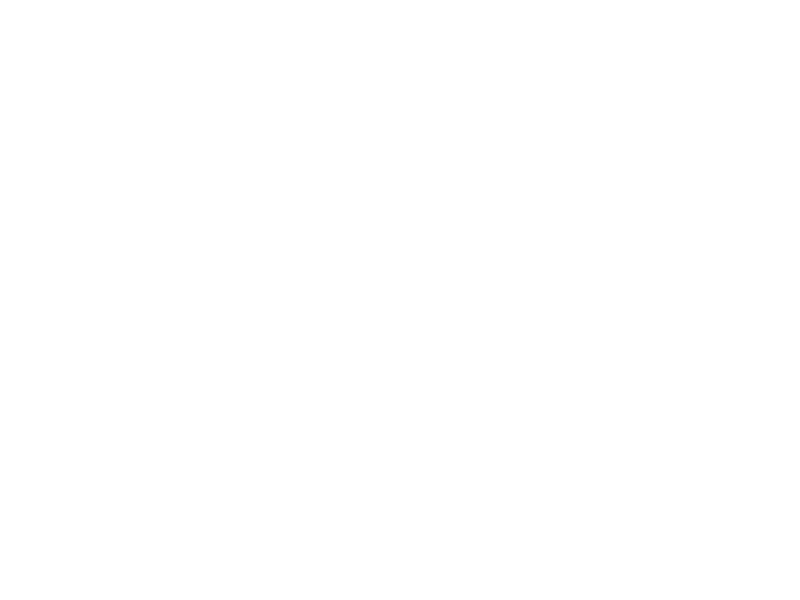

In [3]:
import numpy as np
from imagefunctions import readORLDatabase
from imagefunctions import showblockgray
%matplotlib notebook

# 8-bit grayscale images from Olivetti Research Lab Database
faces,labels,ht,wd,numimages = readORLDatabase('data/ORLfacedatabase/')

showblockgray(faces[:100]) # images of first 10 subjects
facearray = (faces.reshape(numimages,ht*wd)).T # flatten each column

In [4]:
# split faces into training and test sets
np.random.seed(20)
randomized = np.random.permutation(400) 

idx = randomized[:200]

trainset = facearray[:,idx]
trainlabels = labels[idx]

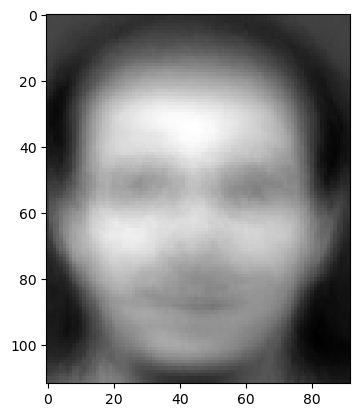

In [5]:
avgface = np.average(trainset,axis=1)

%matplotlib inline
import matplotlib.pyplot as plt

plt.gray()
plt.imshow(avgface.reshape(ht,wd)) # Since the face is a column, we need to reshape to display it
normfaces = (trainset.T - avgface).T # normalized faces array

u, s, vt = np.linalg.svd(normfaces, full_matrices=False) # compute SVD

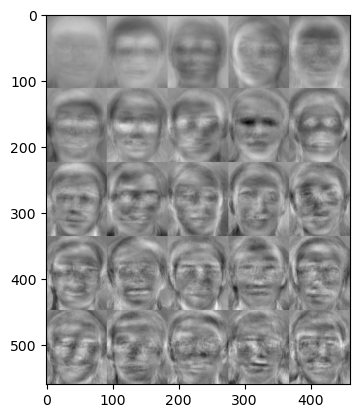

In [6]:
efaces = (u[:,:25].T).reshape(25,ht,wd) # eigenfaces (principal directions)
showblockgray(efaces)

<IPython.core.display.Javascript object>


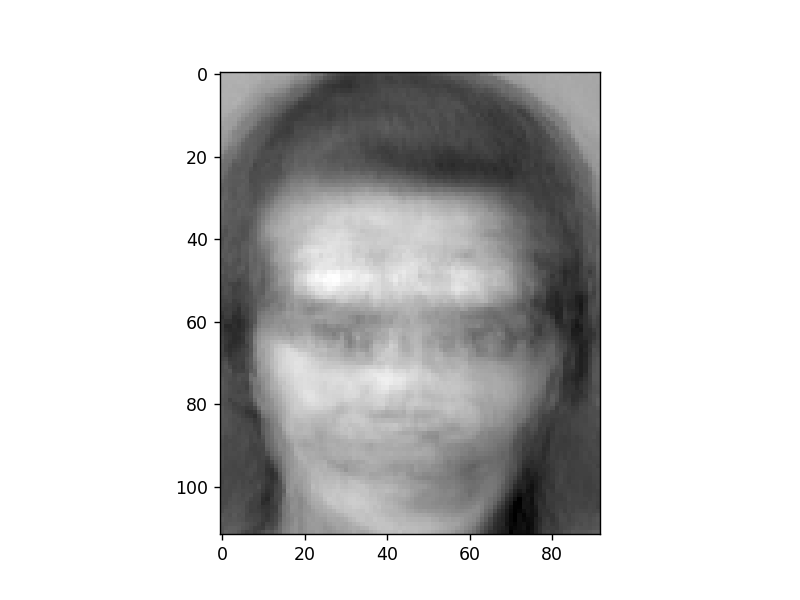

interactive(children=(IntSlider(value=1, continuous_update=False, description='numefaces', max=200, min=1), Ou…

In [7]:
# compute reconstruction of first facial image
# for increasing values of number of eigenfaces
# on an interactive slider -- looks good at about n = 59
f1 = trainset[:,0]

from ipywidgets import interact
import ipywidgets as widgets

%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

@interact(numefaces=widgets.IntSlider(min=1,max=200,step=1,value=1,continuous_update=False))
def update(numefaces):
    ax.imshow((u[:,:numefaces]@u[:,:numefaces].T@normfaces[:,0] + avgface).reshape(ht,wd),cmap='gray') #changing numefaces

### Automated Face Recognition

We now aim to figure out which subject is represented by a given picture. Our strategy will be as follows:
* Create a test set of all images not in our training set. Then subtract the average *of the training set*.<br><br>
* Find the true labels for each of these (we will pretend we don't know these, then test our results against the correct answers).<br><br>
* Find the coordinates of each image along the first $n$ eigenfaces (principal directions) we found before by multiplying by $u_n^T$. Same for the training images.<br><br>
* Find the distances between the coordinates of a given test image and the coordinates of each of the images in the training set.<br><br>
* Predict a label for an unknown image (from the test set) to be the label of the training set image closest to it.

This will give us a set of predicted labels for each image in the test set. We can then find the total number of differences between the correct labels and our predicted ones to find our rate of success.

**Question 7** Implement the above procedure. What are your rates of success for $n$ between, say, 1 and 50? Does there appear to be a ceiling on the possible success rate? How does this compare to your manual recognition from Question 6 above?

> **Notes on implementation:** 
> * You can get the distance between two vectors *u* and *v* by using `np.linalg.norm(u,v)`. 
> * Once you have all the distances in an array *D*, you can use the aggregating function `np.argmin(D,axis=n)` (where you need to figure out what *n* should -- see the first lab) to find the image in the training set closest to each image in the test set.
> * Once you have those, you can use logical indexing to get the labels the model predicts for your images.
> * Of course, there are many ways to do this. The above are just suggestions.

In [10]:
# test set: all idxs not in trainset
# subtract average of training set from test set
# multiplication by U transpose to project into U-space = coordinates whose label is closest
# coordinates for Un transpose * specific face -- search for closest U transpose * face. 
# Multiply U transpose by entire matrix to find which is closest

idx2 = randomized[200:]
testset = facearray[:,idx2] # create test set of images not in training set
normfaces2 = (testset.T - avgface).T # normalize
truelabels = labels[idx2] # true labels for training set

n = 200
un = u[:,:n]
ctest = un.T@normfaces2
ctrain = un.T@normfaces

# distances between a given test image and each of the images in training set
D = np.zeros((200,200))
for f in range(200):
    for i in range(200):
        dist = np.linalg.norm(ctest[:,f] - ctrain[:,i])
        D[i,f] = dist 

minIdx = np.argmin(D, axis = 0)
predictedLabels = trainlabels[minIdx]
#print(predictedLabels)

score = np.sum(predictedLabels==truelabels)/200 # accuracy rate
print("Accuracy score:", score)

Accuracy score: 0.9


~90% success rate